# Import Libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

## Data Loading

In [2]:
# reading the data
data_entry = pd.read_csv("./input/NIH_Dataset/Data_Entry_2017.csv")
data_entry.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
data_entry.shape

(112120, 12)

In [4]:
data_entry.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


## Data Cleaning

In [5]:
#drop unused columns
data_entry = data_entry[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# removing the rows which have patient_age >100
total = len(data_entry)
print('No. of rows before removing rows having age >100 : ',len(data_entry))
data_entry = data_entry[data_entry['Patient Age']<100]
print('No. of rows after removing rows having age >100 : ',len(data_entry))
print('No. of datapoints having age > 100 : ',total-len(data_entry))

No. of rows before removing rows having age >100 :  112120
No. of rows after removing rows having age >100 :  112104
No. of datapoints having age > 100 :  16


In [6]:
# rows having no. of disease
data_entry['Labels_Count'] = data_entry['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

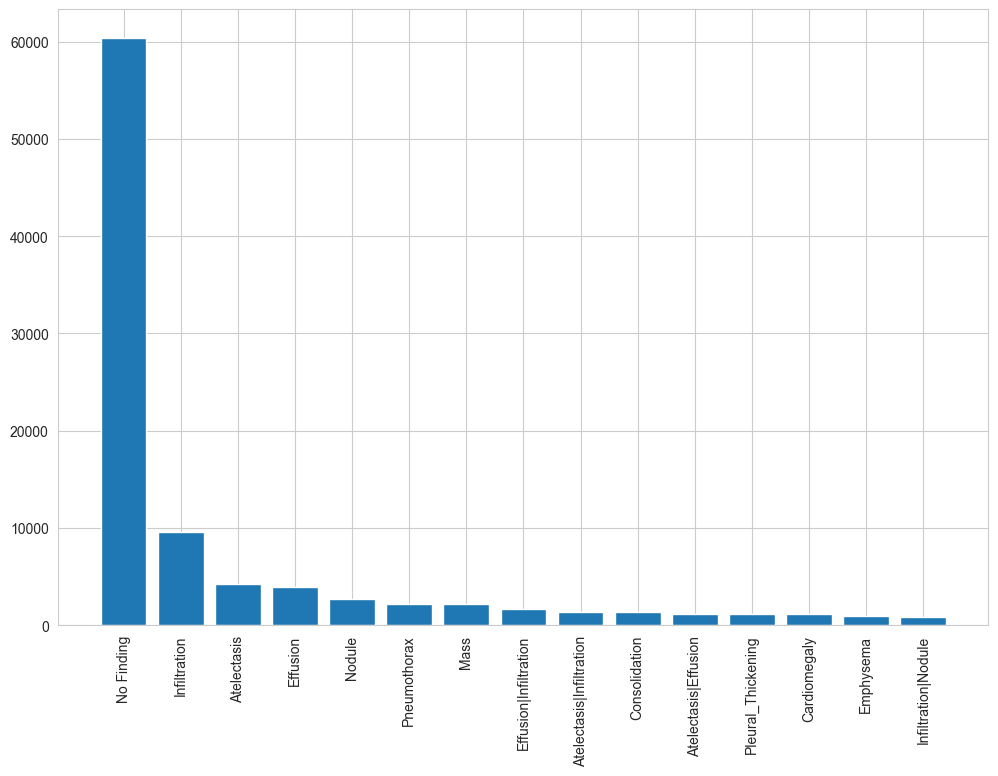

In [7]:
label_counts = data_entry['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

## Data Analysis

### Age Distribution

<Figure size 1000x1000 with 0 Axes>

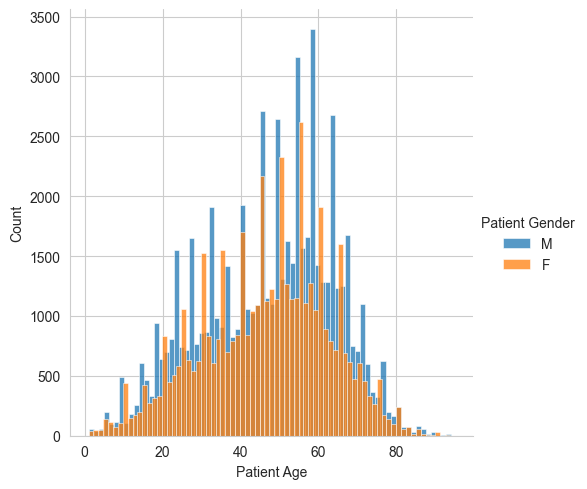

In [14]:
plt.figure(figsize=(10,10))
sns.FacetGrid(data_entry, hue='Patient Gender', height=5).map(sns.histplot,'Patient Age').add_legend()
plt.show()

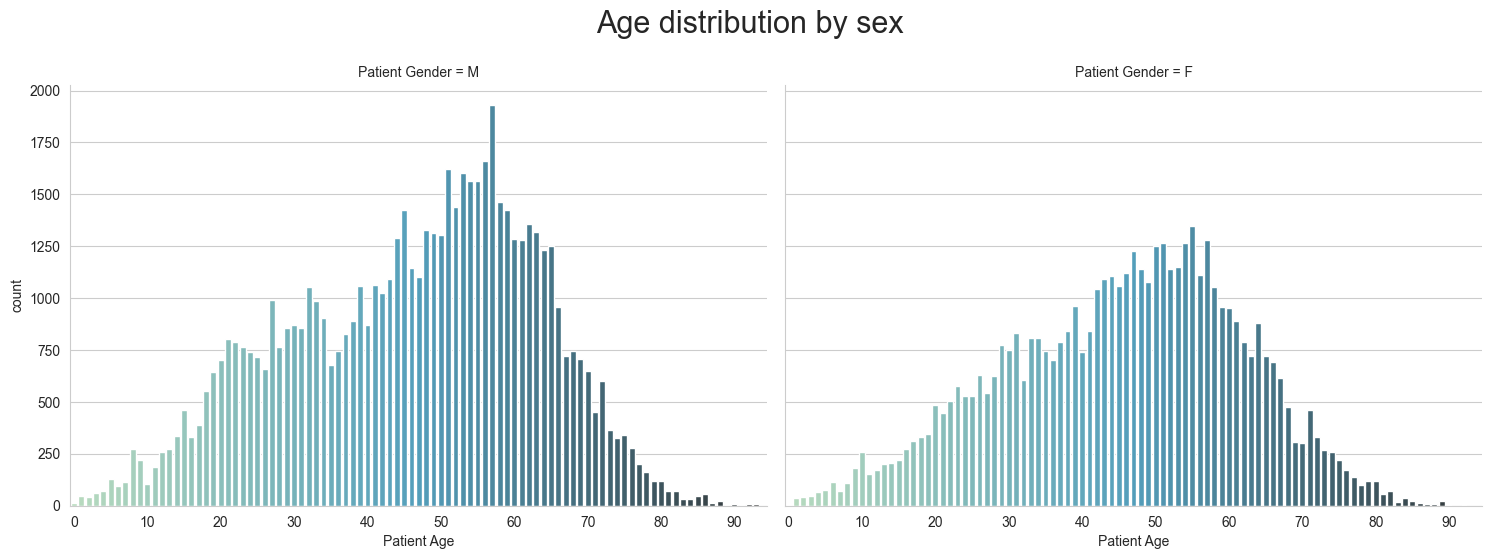

In [23]:
# Creating the plot with seaborn
g = sns.catplot(x="Patient Age", col="Patient Gender", data=data_entry, kind="count",
                height=10, aspect=0.8, palette="GnBu_d")

# Setting custom tick labels on the x-axis
g.set(xticks=np.arange(0, 100, 10))  # Sets ticks at intervals of 10
g.set_xticklabels(np.arange(0, 100, 10))  # Sets tick labels from 0 to 90

# Adjusting the title and its position
g.fig.suptitle('Age distribution by sex', fontsize=22,
               y=1.05)  # Adjust 'y' for better spacing
g.fig.subplots_adjust(top=0.9)  # Adjusts the subplots to fit the title

# Explicitly setting the figure size
g.fig.set_size_inches(15, 5)  # Width, Height in inches

plt.show()

### Disease distribution by age and sex

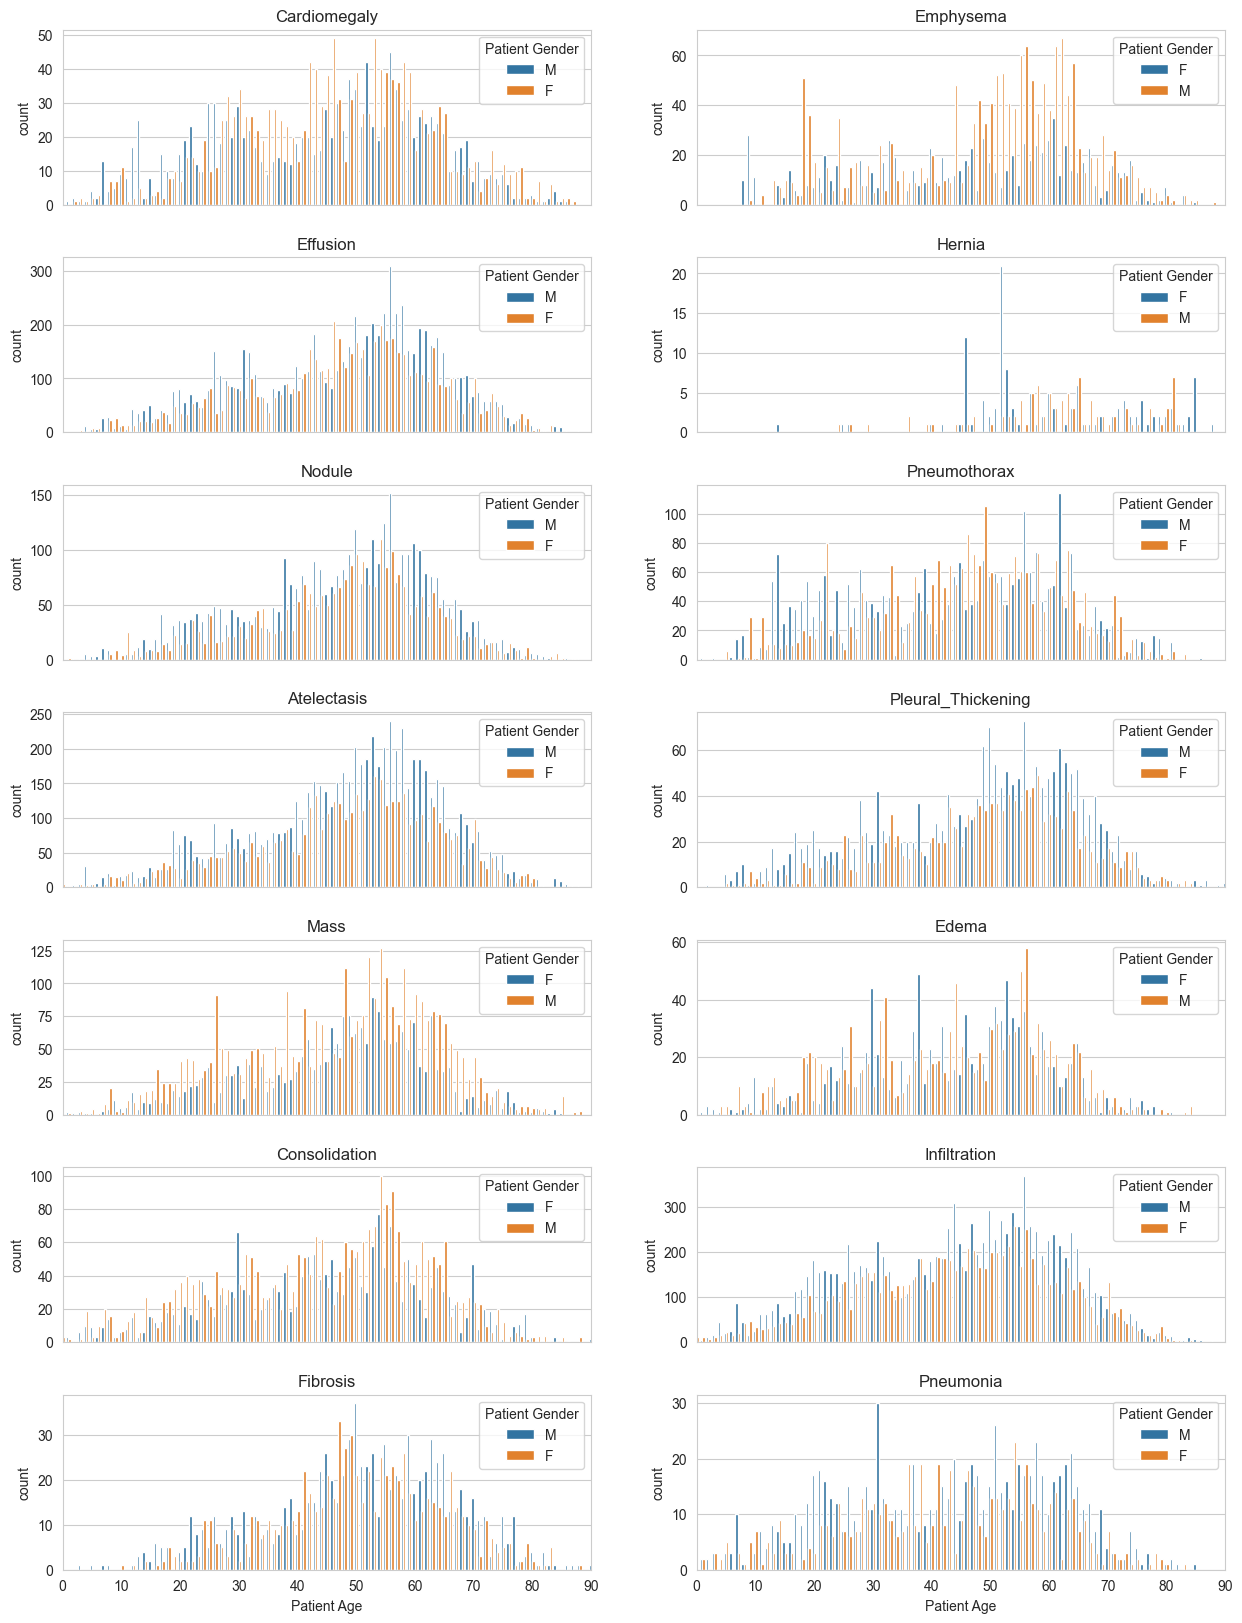

In [24]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
df = data_entry[data_entry['Finding Labels'] != 'No Finding']
i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    index = []
    for k in range(len(df)):
        if pathology in df.iloc[k]['Finding Labels']:
            index.append(k)
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df.iloc[index], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

### No. of each disease by patient gender

In [25]:
for pathology in pathology_list :
    data_entry[pathology] = data_entry['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

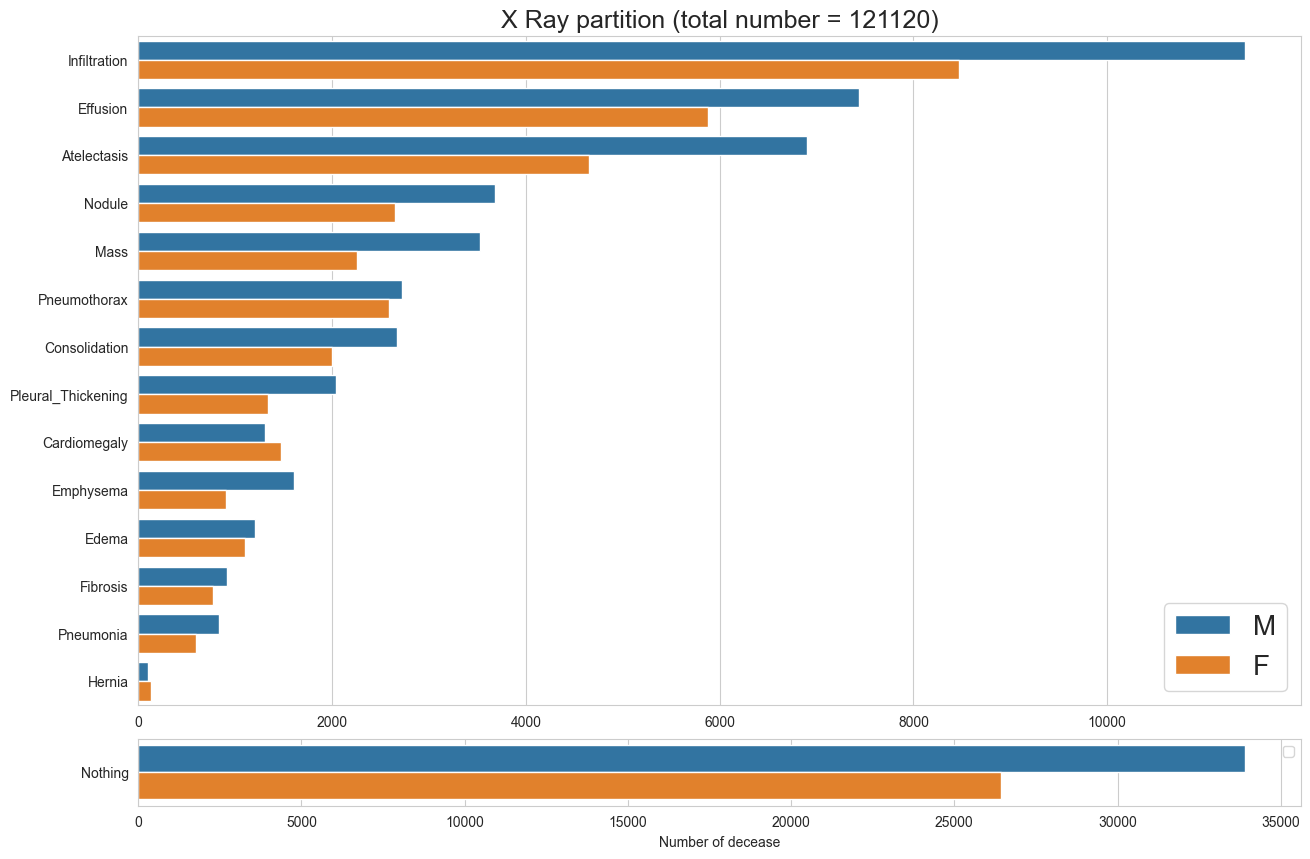

In [26]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(data_entry,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

data_entry['Nothing']=data_entry['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(data_entry,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

### Display patient number by Follow-up in details

In [ ]:
f, (ax1,ax2) = plt.subplots( 2, figsize=(15, 10))

df = data_entry[data_entry['Follow-up #']<15]
g = sns.countplot(x='Follow-up #',data=df,palette="GnBu_d",ax=ax1);

ax1.set_title('Follow-up distribution');
df = data_entry[data_entry['Follow-up #']>14]
g = sns.countplot(x='Follow-up #',data=df,palette="GnBu_d",ax=ax2);
x=np.arange(15,100,10)
g.set_ylim(15,450)
g.set_xlim(15,100)
g.set_xticks(x)
g.set_xticklabels(x)
f.subplots_adjust(top=1)

### ratio between one and multiple disease

In [ ]:
df=data_entry.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

In [ ]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)

### Plot most important pathologies groups for each desease

In [ ]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

In [ ]:
#'Hernia' has not enough values to figure here
df4=df3[df3['Hernia']>0]  # df4.size == 0
#remove 'Hernia' from list
pat_list=[elem for elem in pathology_list if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(10, 140))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('main desease : '+pathology,fontsize=14)   
        i +=1

# Creating data for model

In [8]:
# all_xray_df = pd.read_csv('./input/NIH_Dataset/Data_Entry_2017.csv')
# # Define the base path to your images directory
# base_path = './input/NIH_Dataset'

# # Use glob to find all png images within the nested directories
# all_image_paths = {os.path.basename(x): x for x in 
#                    glob(os.path.join(base_path, 'images*', '*', '*.png'))}
# print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
# all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(str(x).strip()[:-1]) if isinstance(x, str) and x[-1].isdigit() == False else int(x))
# all_xray_df.sample(5)

In [9]:
# # Initialize a list to store the images
# loaded_images = []

# # Iterate over the path column in your DataFrame
# for img_path in all_xray_df['path']:
#     # Read the image from the file system
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale mode; use cv2.IMREAD_COLOR for color
#     if img is not None:
#         loaded_images.append(img)
#     else:
#         print(f"Failed to load image at: {img_path}")

# # Now loaded_images contains all the images and can be processed further
# print(f"Total images loaded: {len(loaded_images)}")